In [1]:
from aux_functions import *

### Información que tiene el decoder

Por ahora voy a suponer que el decoder cuenta con:

-flow_x

-flow_y

-huffman_codebook

-frame_dimensions

-reference_frame

-message

In [2]:
'''
Deco en ppio tiene flow_x, flow_y, residual_image y reference_image
'''

folder_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Mountain'

flow_x_path = os.path.join(folder_path, 'flow_x.npy')
flow_y_path = os.path.join(folder_path, 'flow_y.npy')
symbols_path = os.path.join(folder_path, 'symbols.npy')
codes_path = os.path.join(folder_path, 'codes.npy')
#frame_dim = np.array([480,864])
frame_dim = np.array([864,480])
ref_image_path = os.path.join(folder_path, 'frame_32.tif')
message_path = os.path.join(folder_path, 'message.bin')

In [7]:
#Cargo symbols y codes
symbols = np.load(symbols_path)
codes = np.load(codes_path)

message = read_bin_file(message_path)
print(type(message))

def decode_symbols_2(message, symbols, codes, dimension):
    '''
    Recibe como entrada el mensaje, y el huffman_codebook.
    Devuelve los valores originales de la imagen antes de codificarla.
    TODO: Cuando haga un encabezado con metada tengo que pasarle las dimensiones
          originales de la imagen para hacer reshape, ahora esta flatten.
    '''
    decoded_symbols = []
    coded_symbol = ''
    for c in message:
        coded_symbol += c
        if coded_symbol in codes:
            #print(coded_symbol)
            i = np.where(codes == coded_symbol)
            decoded_symbols.append(symbols[i][0]) #No sé por qué lleva ese 0 ahí..
            coded_symbol = ''
    print(len(decoded_symbols))
    print(decoded_symbols[2])
    return np.array(decoded_symbols)

decoded_file = decode_symbols_2(message, symbols, codes, frame_dim)
print(decoded_file.shape)

Cadena binaria: 000001110000000111100011010100000110100000110100000110100000110100000110100000110100000110100000110101001011010010110101010101010101011010011010011010011010011010011010011010011010011010011010011010011010010010110100101101001011010010110100101101001011011010010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010100111110101001010000011010000011010000011010000011010000011010000011010000011010111111101001011010010110101010101010101011010011010011010011010011010011010011010011010011010011010011010011010010010110100101101001011010010110100101101001011011010010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010101010100100111100111010001011011010110110101101101011011010000001100001000000100110001101010110100110100100101101001011010101010101011010010101101001010101011010010101010101010101010100101101001011011010011010010010110100101101010101010101010101010101111111010101010101010101010101010101

In [12]:
def reconstruct_array(array_salida, original_length):
    reconstructed_array = np.zeros(original_length, dtype=int)
    index = 0
    for zero_count, value, flag in array_salida:
        index += zero_count
        reconstructed_array[index] = value
        index += 1
    return reconstructed_array

decoded_file_list = []
print(decoded_file)
for element in decoded_file:
    decoded_file_list.append(eval(element))
decoded_file_array = np.array(decoded_file_list)
ordered_array = reconstruct_array(decoded_file_array, frame_dim[0]*frame_dim[1])

print(ordered_array)

['(0, 1020, 0)' '(7, 1020, 0)' '(7, 1000, 0)' ... '(1, 10, 0)'
 '(1, -10, 0)' '(1, 10, 1)']
[1020    0    0 ...  -10    0   10]


In [27]:
def completar_con_ceros(array, largo):
    """
    Completa una lista con ceros hasta alcanzar el largo especificado.

    :param lista: Lista original.
    :param largo: Largo deseado para la lista.
    :return: Lista completada con ceros hasta alcanzar el largo especificado.
    """

    lista = array.tolist()


    # Calculamos cuántos ceros necesitamos agregar
    cantidad_ceros = max(0, largo - len(lista))
    
    # Creamos una nueva lista agregando los ceros necesarios
    lista_completada = lista + [0] * cantidad_ceros
    
    return np.array(lista_completada)

full_array = completar_con_ceros(ordered_array, frame_dim[0]*frame_dim[1])
full_array_reshaped = full_array.reshape(frame_dim)
print(full_array_reshaped.shape)

(864, 480)


In [32]:
def idct_2(img_to_transform, output_path):
    #Leo imagen 
    #img_to_transform = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.int16)

    width, height = img_to_transform.shape
    idct_img = np.empty((width, height),dtype=int)
    #img_to_antitransform = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.int16)

    for x in range(0, width, 8):
        for y in range(0, height, 8):
            block = np.array(img_to_transform[x:x+8,y:y+8], dtype=int)
            #print(block.shape)
            #print('x,y: ',x,y)
            idct_block = idctn(block, norm='ortho')  # DCT tipo 2
            idct_img[x:x+8,y:y+8] = idct_block

    # Ejemplo de cálculo de la DCT
    #decoded_residual = idctn(img, norm='ortho')  # DCT tipo 2
    cv2.imwrite(output_path, decoded_residual, [cv2.IMWRITE_TIFF_COMPRESSION, 1])
    return idct_img

idct_path = os.path.join(folder_path, 'IDCT.tif')
decoded_residual = idct_2(full_array_reshaped,idct_path)

In [33]:
print(decoded_residual.shape)
decoded_residual = decoded_residual.reshape(frame_dim)
print(decoded_residual.shape)

(864, 480)
(864, 480)


127
127
127
127


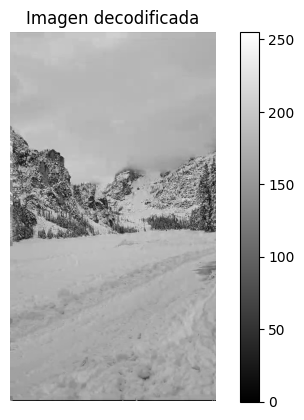

In [34]:
#Pruebo obtener la imagen final, voy a probar primero usando directamente el frame con motion compensation
#mc: motion_compensation

mc_ref_path = os.path.join(folder_path, 'corrected_reference.tif')
mc_ref_image = cv2.imread(mc_ref_path, cv2.IMREAD_GRAYSCALE)
idct_image_16bits_int_list = [np.round(value) for value in decoded_residual]
idct_image_16bits_int_array = np.array(idct_image_16bits_int_list)
idct_image_8bits = idct_image_16bits_int_array.astype(np.uint8)
decoded_image = mc_ref_image + idct_image_8bits - 128

print(decoded_residual[100][100])
print(idct_image_16bits_int_list[100][100])
print(idct_image_16bits_int_array[100][100])
print(idct_image_8bits[100][100])

decoded_image_path = os.path.join(folder_path, 'decoded_image.tif')
cv2.imwrite(decoded_image_path, decoded_image, [cv2.IMWRITE_TIFF_COMPRESSION, 1])

plt.imshow(decoded_image, cmap='gray', vmin=0, vmax=np.max(decoded_image))
plt.colorbar()
plt.title('Imagen decodificada')
plt.axis('off')  # Ocultar ejes
plt.show()

In [7]:
# # Cargar los archivos flow_x.npy y flow_y.npy
# flow_x = np.load(flow_x_path)
# flow_y = np.load(flow_y_path)


# # Leo imágenes de referencia y residual
# ref_image = cv2.imread(ref_image_path, cv2.IMREAD_GRAYSCALE).astype(np.int16)
# residual_image = cv2.imread(residual_path, cv2.IMREAD_GRAYSCALE).astype(np.int16)

# #Calculo la suma entre ambas, resto 128 por offset de imagen residual
# added_images = residual_image - 128 + ref_image

# #Ploteo resultado
# plt.imshow(added_images, cmap='gray')
# plt.axis('off')  # Ocultar ejes
# plt.show()

# #Guardo resultado
# output_path =  '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/decoded_image_without_motion_correction.png'
# cv2.imwrite(output_path, added_images)

NameError: name 'residual_path' is not defined

In [ ]:
# added_images_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/decoded_image_without_motion_correction.png'

# output_path = '/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/decoder_motion_corrected_frame_npwhere_reference_based.png'

# decoder_motion_correction(added_images_path, ref_image_path, flow_x_path, flow_y_path, output_path)

Current frame con motion correction guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/decoder_motion_corrected_frame_npwhere_reference_based.png


In [ ]:
# current_frame_image = cv2.imread('/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/DCM_7x7_image.png')
# estimated_frame_image = cv2.imread('/Users/diegosilveracoeff/Desktop/Fing/DCM/Synthetic_Gaussian/decoder_motion_corrected_frame_npwhere_reference_based.png')

# print(np.sum(np.abs(current_frame_image-estimated_frame_image)))

0


In [ ]:
# Pruebo la decodificación con la imagen de referencia 

